In [1]:
# prepare data and compute metrics

import duckdb
from glob import glob
import re
from os.path import basename
import polars as pl
import itertools as it

con = duckdb.connect(database=':memory:')

con.sql('''
    create or replace table coins as
    with stables as (
        select unnest(['dai','bsc-usd','busd','eurc','c1usd','susds','usd1','bfusd','fdusd','pyusd','rlusd','steakusdc','syrupusdc',
           'syrupusdt','tusd','usd0','usdai','usdb','usdc.e','usdc','usdd','usde','usdf',
           'usdg','usds','usdt','usdt0','usdtb','usdy']) as symbol
    ), raw as (
        select distinct on (ts, symbol)
            timestamp as ts,
            regexp_extract(filename, 'pd-data/(.+)\\.parquet', 1) as symbol,
            price as close,
            -- volume in USD
            total_volume as volume
        from read_parquet('pd-data/*.parquet', filename=true)
        where price is not null
          and total_volume > 0
        order by ts desc

    -- all non-stablecoins
    ), base as (
        select
            r.ts,
            r.symbol,
            r.close,
            r.volume
        from raw r
        where not exists (select 1 from stables s where s.symbol = r.symbol)
          and symbol is not null
    ), ocv as (
        select
            b.ts,
            b.symbol,
            b.close,
            
            -- crypto trades 24/7 yesterday's close = today's open
            bb.close as open,
            
            -- today's log return
            ln(b.close / open) as ret,

            b.volume,
            bb.volume as pvol
        from base b
        asof join base bb
            on b.symbol = bb.symbol
            and bb.ts < b.ts
        where b.ts - bb.ts <= interval '25 hour'
        
    -- time series price momentum
    ), features as (
        select 
            b.ts, 
            b.symbol,
 
            -- 15d volume level
            ln(b.pvol / mean(b.volume) over (
                partition by b.symbol
                order by b.ts 
                rows between 15 preceding and 1 preceding
            )) as vol15d,

            -- 1d momentum
            sum(b.ret) over (
                partition by b.symbol
                order by b.ts 
                rows between 1 preceding and 1 preceding
            ) as mom1d,

             -- 5d momentum
            sum(b.ret) over (
                partition by b.symbol
                order by b.ts 
                rows between 5 preceding and 1 preceding
            ) as mom5d,
            
             -- 10d momentum
            sum(b.ret) over (
                partition by b.symbol
                order by b.ts 
                rows between 10 preceding and 1 preceding
            ) as mom10d,
            
             -- 15d momentum
            sum(b.ret) over (
                partition by b.symbol
                order by b.ts 
                rows between 15 preceding and 1 preceding
            ) as mom15d,
            
             -- 30d momentum
            sum(b.ret) over (
                partition by b.symbol
                order by b.ts 
                rows between 30 preceding and 1 preceding
            ) as mom30d,

            -- 60d momentum
            sum(b.ret) over (
                partition by b.symbol
                order by b.ts 
                rows between 60 preceding and 1 preceding
            ) as mom60d

        from ocv b
    ), narrow as (
        unpivot features
        on mom1d, mom5d, mom10d, mom15d, mom30d, mom60d, vol15d
        into
            name feature value value
    ), z as (
        select
            ts, symbol, feature,
            (value - mean(value) over tsw) / stddev(value) over tsw as zscore
        from narrow
        where value is not null and isfinite(value)
        window tsw as (partition by symbol, feature order by ts 
                        rows between 365 preceding and 1 preceding)
    ), norm as (
        pivot z
        on feature
        using any_value(zscore)
    )
    select
        n.ts, n.symbol, n.mom1d, n.mom5d, n.mom10d, n.mom15d, n.mom30d, n.mom60d, n.vol15d,
        b.ret, b.pvol as vol
    from norm n
    join ocv b on n.ts = b.ts and n.symbol = b.symbol
''')

In [132]:
import numpy as np
import pandas as pd
from chronos import Chronos2Pipeline
import datetime as dt
from tqdm import tqdm

mdf = con.sql('''
select
    c.ts,
    c.symbol,
    c.mom1d,
    c.mom30d,
    c.ret,
    c.vol,
    c.vol15d
    --cc.ret as ref
from coins c
join coins cc on c.ts = cc.ts
where cc.symbol = 'btc' and year(c.ts) >= 2020
order by c.ts, c.symbol
''').pl().to_pandas()

pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="cpu")
pred = []

lookback = 60
lookforward = 1

for td in tqdm(sorted(mdf['ts'].unique())):
    lb = td - dt.timedelta(days=lookback)

    df = mdf[(mdf['ts'] >= lb) & (mdf['ts'] <= td)].copy()
  
    # make sure all coins have are a continouos, daily timeseries
    df.dropna(inplace=True)
    df.sort_values(['symbol','ts'], inplace=True)
    df.set_index('ts', inplace=True)
    df = df.groupby('symbol', group_keys=False)[df.columns].apply(
        lambda g: g.reindex(pd.date_range(start=g.index.min(), end=g.index.max(), freq='D')))
    df['symbol'] = df['symbol'].ffill().bfill()
    df.reset_index(inplace=True)
    df.rename(columns={'index':'ts'}, inplace=True)
    
    # keep only coins that are still traded
    latest = df['ts'].max()
    avail = df[df['ts'] == latest]['symbol'].unique()
    df = df[df['symbol'].isin(avail)]
    
    # keep only coins with the full lookback period of data
    mindata = map(lambda p: p[0], filter(lambda p: p[1] >= lookback, df['symbol'].value_counts().to_dict().items()))
    df = df[df['symbol'].isin(mindata)]
    
    if df.empty:
        continue
        
    # Generate predictions with covariates
    pdf = pipeline.predict_df(
        df,
        prediction_length=lookforward,
        quantile_levels=[0.5],
        id_column="symbol",
        timestamp_column="ts",
        target="ret",
        validate_inputs=True,
        cross_learning=True,
    )
    pdf = pdf.groupby('symbol').agg({'0.5': 'sum', 'ts':'max'}).reset_index()
    pdf.rename(columns={'ts': 'hori','0.5':'ret'}, inplace=True)
    pdf['ts'] = td

    pred.append(pdf)

pd.concat(pred).to_parquet('pred-wx-60lb-1fc-pd.parquet', engine='pyarrow', compression='zstd')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2141/2141 [3:23:21<00:00,  5.70s/it]


In [98]:
# make sure all coins have are a continouos, daily timeseries
df.dropna(inplace=True)
df.sort_values(['symbol','ts'], inplace=True)
df.set_index('ts', inplace=True)
df = df.groupby('symbol', group_keys=False)[df.columns].apply(
    lambda g: g.reindex(pd.date_range(start=g.index.min(), end=g.index.max(), freq='D')))
df['symbol'] = df['symbol'].ffill().bfill()
df.reset_index(inplace=True)
df.rename(columns={'index':'ts'}, inplace=True)

# keep only coins that are still traded
latest = df['ts'].max()
avail = df[df['ts'] == latest]['symbol'].unique()
df = df[df['symbol'].isin(avail)]

# keep only coins with at least one month of data
mindata = map(lambda p: p[0], filter(lambda p: p[1] > 30, df['symbol'].value_counts().to_dict().items()))
df = df[df['symbol'].isin(mindata)]

pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="cpu")

# Generate predictions with covariates
pred_df = pipeline.predict_df(
    df,
    prediction_length=1,
    quantile_levels=[0.5],
    id_column="symbol",
    timestamp_column="ts",
    target="ret",
    validate_inputs=True,
)

<Axes: xlabel='ts'>

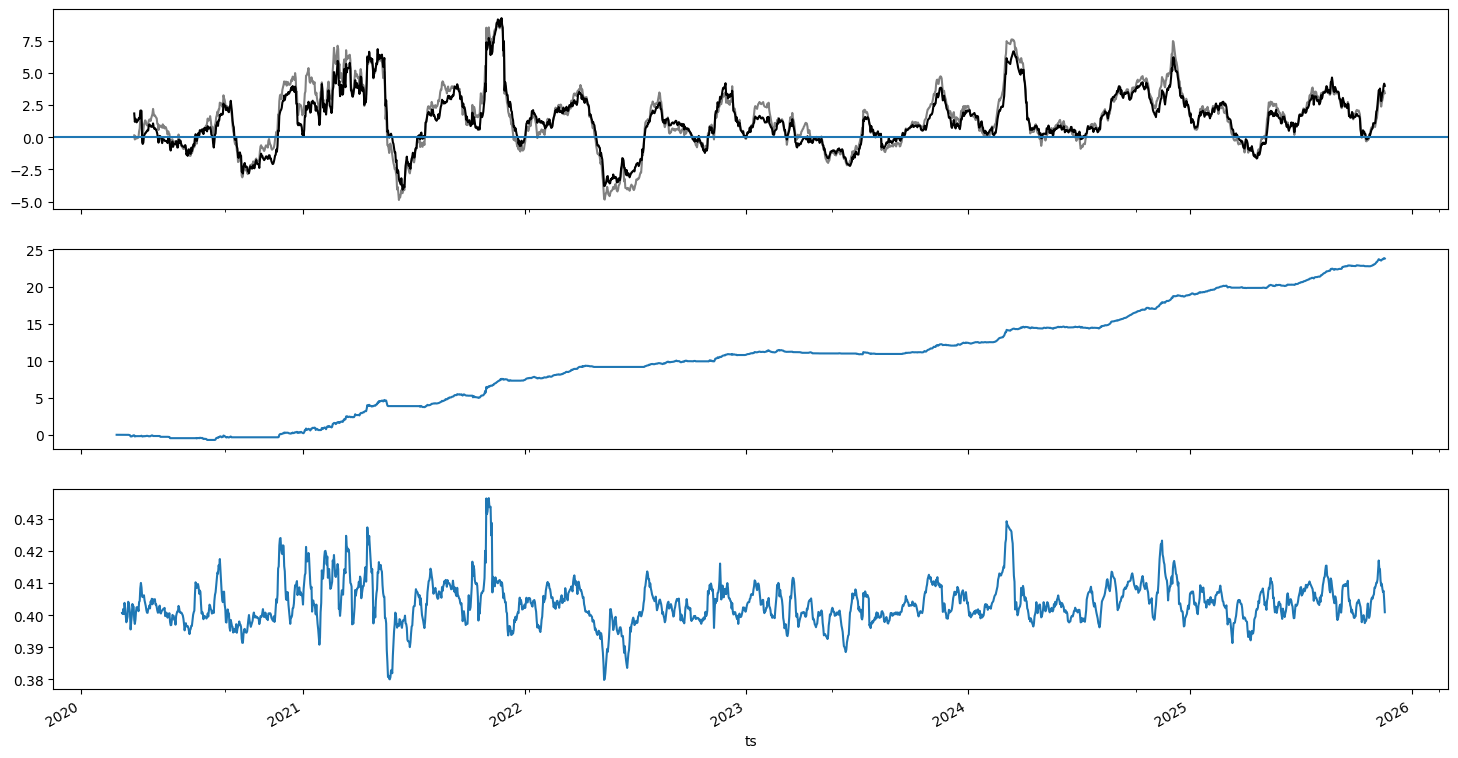

In [143]:
df = con.sql('''
select
    c.ts,
    c.symbol,
    c.ret,
    c.vol,
    cc.ret as ref
from coins c
join coins cc on c.ts = cc.ts
where cc.symbol = 'btc' and year(c.ts) >= 2020
order by c.ts, c.symbol
''').pl().join(pl.read_parquet('pred-nox-60lb-1fc-pd.parquet'), on=['ts','symbol'], how='inner')

df = df.rename({'ret_right': 'pred'}).drop('__index_level_0__')
df


df = df.with_columns([
    pl.col('pred').qcut(
        10, 
        allow_duplicates=True, 
        labels=list(map(lambda n: f'{n}', range(1,11)))
    ).over('ts').alias('rank'),
]).filter([
    pl.col('rank') == '10', pl.col('pred') > 0
]).with_columns([
    (pl.col('vol') / pl.col('vol').sum().over(['ts'])).alias('weight')
]).sort(['ts','symbol']).with_columns([
    pl.col('weight').alias('initial'),
    (pl.col('weight') * pl.col('ret').exp()).alias('eod')
]).with_columns([
    ((pl.col('eod').abs() + pl.col('initial').abs()) * 0.002).alias('fee'),
]).with_columns([
    (pl.col('eod') - pl.col('initial') - pl.col('fee')).alias('pnl'),
])
  
res = df.sort('ts').group_by('ts').agg([
    (1 + pl.col('pnl').sum()).log().alias('strategy'),
    pl.col('fee').sum().alias('fee'),
    pl.col('ref').first(),
]).sort(['ts']).with_columns([
    (pl.col('strategy') - pl.col('ref')).alias('perf'),
]).with_columns([
    pl.when(
        pl.col('perf').shift(1).rolling_mean(20) >= 0).then(pl.col('perf')).otherwise(0).alias('cond')
]).with_columns([
    pl.col('cond').cum_sum().alias('equity'),
]).to_pandas().set_index('ts').sort_index()

fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(18,10), sharex=True)

((np.exp(res.strategy) - 1) * 100).rolling(30).mean().plot(y='strategy',ax=ax1,color='gray')
((np.exp(res.perf) - 1) * 100).rolling(30).mean().plot(y='perf',ax=ax1,color='black')
ax1.axhline(0)
res.equity.plot(y='equity',ax=ax2)
(res.fee * 100).rolling(10).mean().plot(y='fee',ax=ax3)

<Axes: xlabel='ts'>

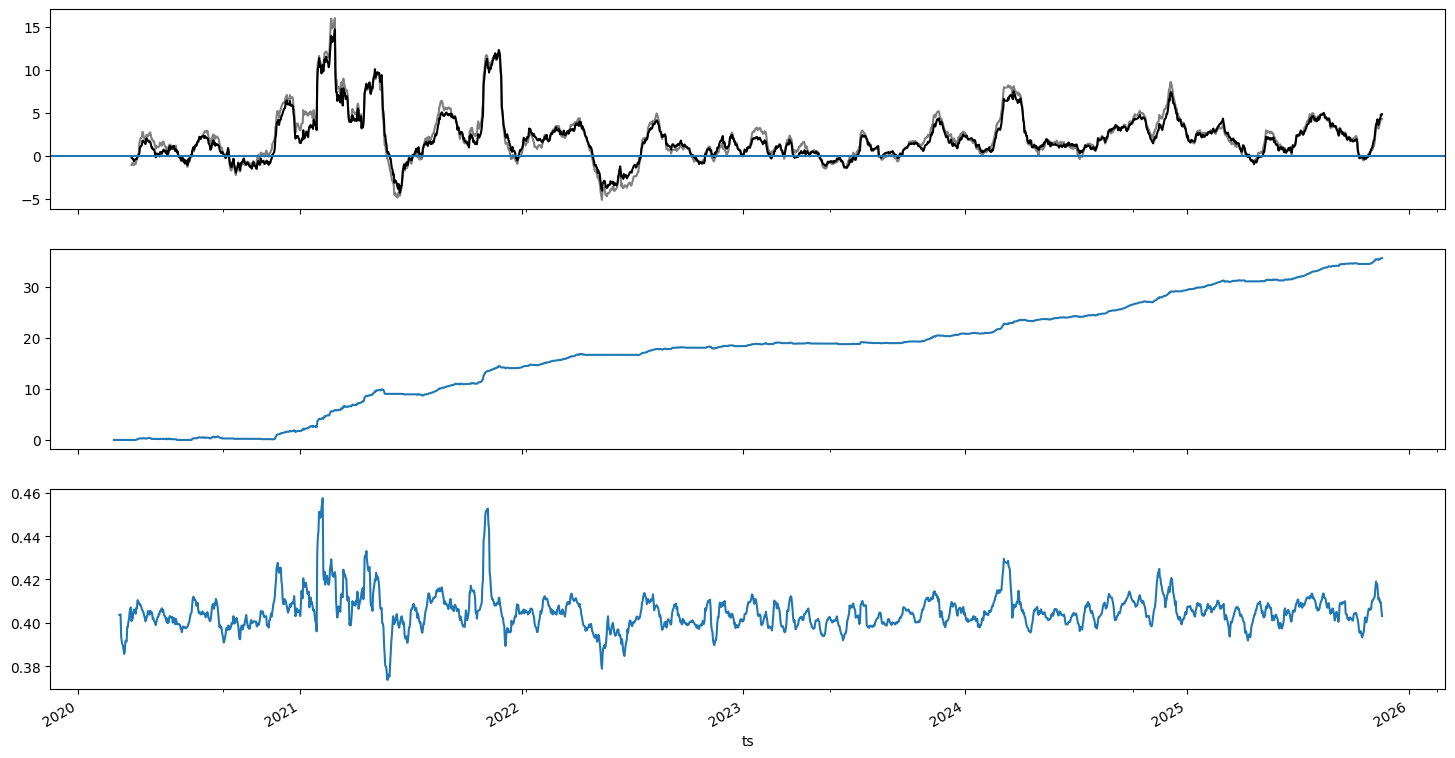

In [144]:
df = con.sql('''
select
    c.ts,
    c.symbol,
    c.ret,
    c.vol,
    cc.ret as ref
from coins c
join coins cc on c.ts = cc.ts
where cc.symbol = 'btc' and year(c.ts) >= 2020
order by c.ts, c.symbol
''').pl().join(pl.read_parquet('pred-wx-60lb-1fc-pd.parquet'), on=['ts','symbol'], how='inner')

df = df.rename({'ret_right': 'pred'}).drop('__index_level_0__')
df


df = df.with_columns([
    pl.col('pred').qcut(
        10, 
        allow_duplicates=True, 
        labels=list(map(lambda n: f'{n}', range(1,11)))
    ).over('ts').alias('rank'),
]).filter([
    pl.col('rank') == '10', pl.col('pred') > 0
]).with_columns([
    (pl.col('vol') / pl.col('vol').sum().over(['ts'])).alias('weight')
]).sort(['ts','symbol']).with_columns([
    pl.col('weight').alias('initial'),
    (pl.col('weight') * pl.col('ret').exp()).alias('eod')
]).with_columns([
    ((pl.col('eod').abs() + pl.col('initial').abs()) * 0.002).alias('fee'),
]).with_columns([
    (pl.col('eod') - pl.col('initial') - pl.col('fee')).alias('pnl'),
])
  
res = df.sort('ts').group_by('ts').agg([
    (1 + pl.col('pnl').sum()).log().alias('strategy'),
    pl.col('fee').sum().alias('fee'),
    pl.col('ref').first(),
]).sort(['ts']).with_columns([
    (pl.col('strategy') - pl.col('ref')).alias('perf'),
]).with_columns([
    pl.when(
        pl.col('perf').shift(1).rolling_mean(20) >= 0).then(pl.col('perf')).otherwise(0).alias('cond')
]).with_columns([
    pl.col('cond').cum_sum().alias('equity'),
]).to_pandas().set_index('ts').sort_index()

fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(18,10), sharex=True)

((np.exp(res.strategy) - 1) * 100).rolling(30).mean().plot(y='strategy',ax=ax1,color='gray')
((np.exp(res.perf) - 1) * 100).rolling(30).mean().plot(y='perf',ax=ax1,color='black')
ax1.axhline(0)
res.equity.plot(y='equity',ax=ax2)
(res.fee * 100).rolling(10).mean().plot(y='fee',ax=ax3)